# __Esercizio__: Modello della sezione d'urto di produzione della $J/\psi$ con una regressione polinomiale

In questo esercizio mostreremo come utilizzare una regressione polinomiale per costruire un modello statistico relativamente complesso in due dimensioni.
Prenderemo come esempio la sezione d'urto di produzione del mesone $J/\psi$ per la quale esistono misure in diversi bin di momento trasverso $p_{\mathrm{T}}$ e rapidità $y$.

Useremo le misure ottenute dall'esperimento LHCb in collisioni protone-protone con un energia nel centro di massa $\sqrt s = 5\ \mathrm{TeV}$.
Gli esperimenti di LHC (e non solo) raccolgono i risultati che possono essere utilizzati per migliorare i modelli efficaci di QCD nel portale [HepData](https://www.hepdata.net/).  

In particolare, i dati che ci interessano possono sono identificati dall'indice [`ins1915030`](https://www.hepdata.net/record/ins1915030).


## Caricamento dei dati da HepData
La conversione dei dati dal formato con cui sono caricati in HepData, ad oggetti processabili in Python richiede un po' di ginnastica (e non vi sarà chiesto di farlo in sede d'esame).

Per prima cosa scarichiamo i dati in formato **yaml** e carichiamoli con la libreria python per questo potente linguaggio.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import yaml

!wget "https://www.hepdata.net/download/table/ins1915030/Table%201/1/yaml" -O data.yaml -q
dataset = yaml.safe_load(open('data.yaml'))

Quindi trasformiamo il dataset in un formato più maneggevole: l'obiettivo è costruire una tabella in cui per ogni riga riportiamo il valore centrale del bin in $p_{\mathrm T}$, il valore centrale del bin in rapidity $y$ ed il corrispondente valore della sezione d'urto (`xsec`) con il suo errore (`err`).

In [ ]:
import pandas as pd

pt_var = dataset['independent_variables'][0]
pt_bins = []

y_boundaries = []
parsed_data = []

for pt in pt_var['values']:
  pt_bins.append ([pt['low'], pt['high']])

for row in dataset['dependent_variables']:
  ymin, ymax = [q['value']  for q in row['qualifiers'] if q['name']=='YRAP'][0].split('-')
  ymin, ymax = float(ymin), float(ymax)
  y_boundaries += [ymin, ymax]
  values = [v['value'] for v in row['values']]
  errors = [sum (err['symerror']**2 for err in error['errors'])**0.5 for error in row['values']]
  for (pt_min, pt_max), cross_section, error in zip(pt_bins, values, errors):
    parsed_data.append([float(pt_min + pt_max)/2, float(ymin + ymax)/2, cross_section, error])

y_boundaries = sorted(set(y_boundaries))
data = pd.DataFrame (np.array(parsed_data), columns=["pT", "y", "xsec", 'err'])

data.head()

,pT,y,xsec,err
0,0.5,2.25,686.03,37.211549
1,1.5,2.25,1253.23,59.127593
2,2.5,2.25,964.82,43.069957
3,3.5,2.25,575.26,23.477466
4,4.5,2.25,305.38,11.489034


## Plot del dataset
Il plot pubblicato da LHCb è il seguente:
![image.png](https://www.hepdata.net/record/resource/2760209?view=true)

Cerchiamo di riprodurre un plot analogo a partire dai dati contenuti nel dataset ottenuto da HepData.

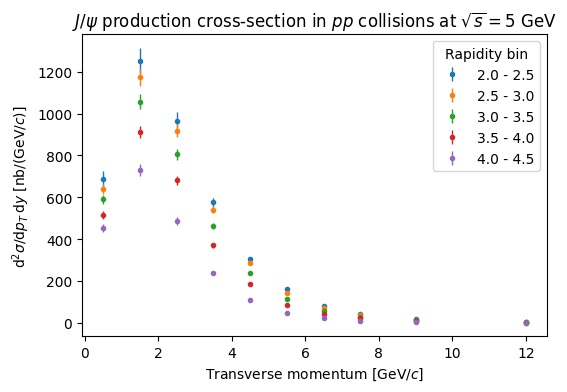

In [ ]:
plt.figure(dpi=100)
for ymin, ymax in zip(y_boundaries[:-1], y_boundaries[1:]):
  # Seleziono un sotto-dataset in un determinato invervallo di y
  bindata = data.query(f'y > {ymin} and y < {ymax}')
  plt.errorbar(bindata.pT, bindata.xsec, bindata.err, fmt='o', label=f"{ymin} - {ymax}", markersize=3, linewidth=1)

plt.title("$J/\psi$ production cross-section in $pp$ collisions at $\sqrt{s} = 5$ GeV" )
plt.legend(title="Rapidity bin")
plt.xlabel("Transverse momentum [GeV/$c$]")
plt.ylabel("$\mathrm{d}^2\sigma/\mathrm{d}p_{T}\, \mathrm{d}y$ [nb/(GeV/$c$)]")
plt.yscale('linear')
plt.show()

## Costruzione del modello polinomiale

Costruiamo un modello polinomiale dato l'ordine massimo dei polinomi in $p_\mathrm{T}$ e $y$, chiamiamoli $k_p$ e $h_y$.

Allora cerchiamo di rappresentare la sezione d'urto come
$$
\frac{\mathrm{d}^2 \hat \sigma}{\mathrm {d} p_T \mathrm{d} y } = \sum_{i=0}^{k_p-1}\sum_{j=0}^{k_y-1}\, a_{ij}\, p_T^{i} y^j
$$

dove ciascun $a_{ij}$ è un coefficiente da ottimizzare con la procedura di fit.

### Pipeline
Per riuscire in questo problema, è importante trasformare le variabili con uno step di preprocessing. Invece che separare quest'ultimo dallo step di regressione vero e proprio, vediamo come possiamo combinarli entrambi in una pipeline che ci consenta di creare un nuovo oggetto che concateni i diversi step.


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

gx, gy = 8, 3

lr = Pipeline ([
                ('preprocessing', StandardScaler()),
                ('regressor', LinearRegression ())
               ])

X = np.stack([data.pT**j * data.y**k for j in range(gx) for k in range(gy)]).T
y = np.log(np.c_[data.xsec])
w = 1./np.array(data.err)**2

lr.fit(X, y, regressor__sample_weight=w)

Pipeline(steps=[('preprocessing', StandardScaler()),
                ('regressor', LinearRegression())])

## Visualizzazione del modello
Infine visualizziamo il modello ottenuto sovrapposto al grafico.
Possiamo scegliere l'ordine del polinomio in $p_T$ ed $y$ per bilanciare tra *underfitting* (certamente non stiamo cercando di descrivere una relazione lineare o quadratica...) e *overfitting* (purtroppo abbiamo pochi punti a disposizione).

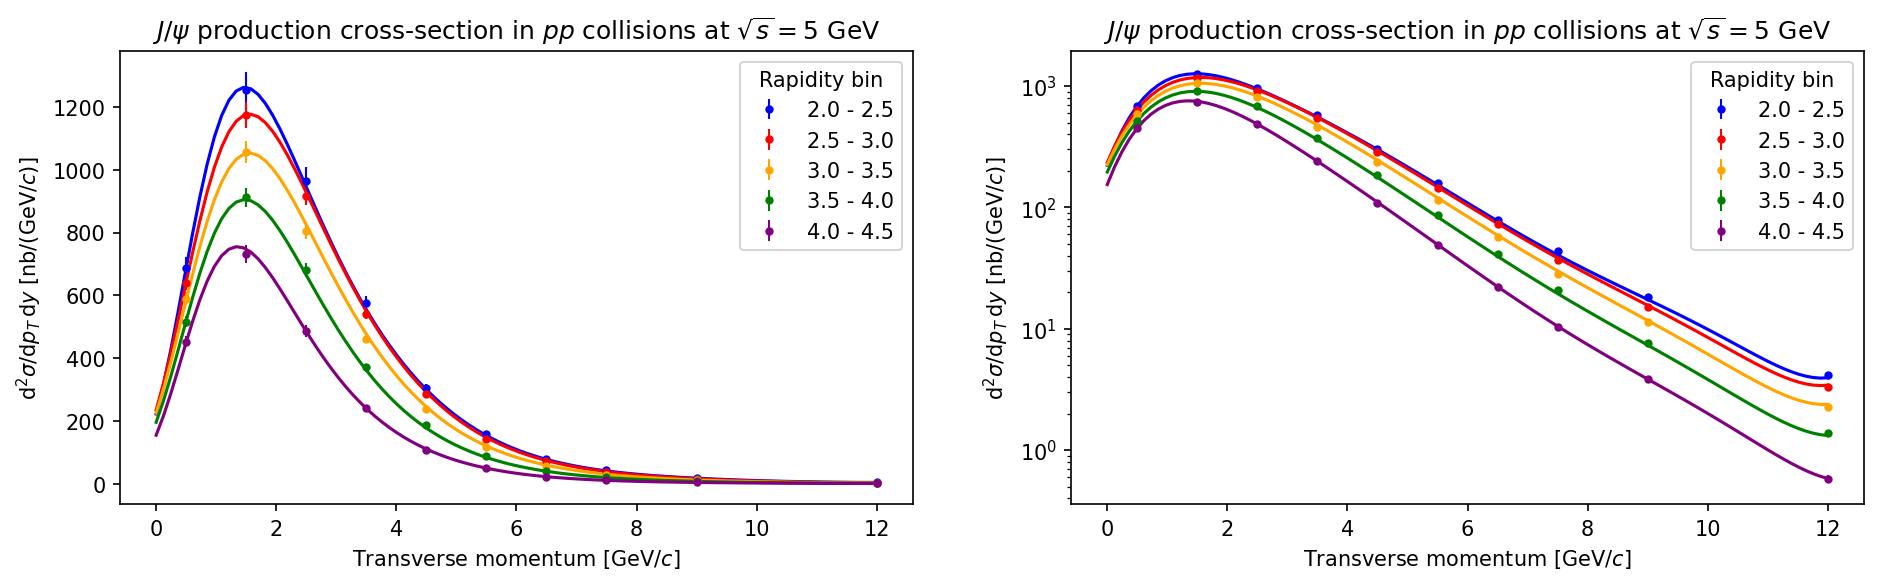

In [ ]:
plt.figure(figsize=(15,4), dpi=150)
plt.subplot(1,2,1)

xAxis = np.linspace(0, 12, 100)

colors = ['blue', 'red', 'orange', 'green', 'purple', 'magenta']

for ymin, ymax, color in zip(y_boundaries[:-1], y_boundaries[1:], colors):
  bindata = data.query(f"y > {ymin} and y < {ymax}")
  ybest = 0.5*(ymin + ymax)
  yAxis = np.full_like(xAxis, ybest)
  Xcols = np.stack([xAxis**j * yAxis**k for j in range(gx) for k in range(gy)]).T

  y_hat = np.exp(lr.predict(np.c_[Xcols,]))
  plt.errorbar(bindata.pT, bindata.xsec, bindata.err, fmt='o', label=f"{ymin} - {ymax}", markersize=3, linewidth=1, color=color)
  plt.plot (xAxis, y_hat, color=color)

plt.yscale('linear')
plt.title("$J/\psi$ production cross-section in $pp$ collisions at $\sqrt{s} = 5$ GeV" )
plt.legend(title="Rapidity bin")
plt.xlabel("Transverse momentum [GeV/$c$]")
plt.ylabel("$\mathrm{d}^2\sigma/\mathrm{d}p_{T}\, \mathrm{d}y$ [nb/(GeV/$c$)]")

plt.subplot(1,2,2)

for ymin, ymax, color in zip(y_boundaries[:-1], y_boundaries[1:], colors):
  bindata = data.query(f"y > {ymin} and y < {ymax}")
  ybest = 0.5*(ymin + ymax)
  yAxis = np.full_like(xAxis, ybest)
  Xcols = np.stack([xAxis**j * yAxis**k for j in range(gx) for k in range(gy)]).T

  y_hat = np.exp(lr.predict(np.c_[Xcols]))
  plt.errorbar(bindata.pT, bindata.xsec, bindata.err, fmt='o', label=f"{ymin} - {ymax}", markersize=3, linewidth=1, color=color)
  plt.plot (xAxis, y_hat, color=color)

plt.yscale('log')
plt.title("$J/\psi$ production cross-section in $pp$ collisions at $\sqrt{s} = 5$ GeV" )
plt.legend(title="Rapidity bin")
plt.xlabel("Transverse momentum [GeV/$c$]")
plt.ylabel("$\mathrm{d}^2\sigma/\mathrm{d}p_{T}\, \mathrm{d}y$ [nb/(GeV/$c$)]")
plt.show()

## Conclusione
In questo esercizio abbiamo visto come estendere il modello lineare per descrivere un problema non lineare in due dimensioni come un problema lineare in decine di variabili.
Abbiamo mostrato un esempio della difficoltà di bilanciare tra *underfitting* e *overfitting* quando il modello è di natura *non-parametrica* (cioè non abbiamo speranza di leggere nulla di fisico nel valore assunto dai parametri).

Dal punto di vista del codice, abbiamo visto l'utilizzo delle Pipeline di scikit-learn che consentono di combinare step di *preprocessing* a step di regressione, e abbiamo visto un esempio di grafico con barre d'errore ottenuto con `matplotlib`.
